<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/Classifiers/myLightGBMClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification LightGBM

## Cloner la branche contenant le dataset le code qui va avec.

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 922, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 922 (delta 97), reused 182 (delta 85), pack-reused 717
Receiving objects: 100% (922/922), 128.07 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (387/387), done.
total 484
drwxr-xr-x 2 root root   4096 Oct 29 16:22 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 AllstateClaimsSeverity/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 Data/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 EMTboost/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 Models/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 Notebooks/
drwxr-xr-x 2 root root   4096 Oct 29 16:22 Plots/
-rw-r--r-- 1 root root     54 Oct 29 16:22 README.md
drwxr-xr-x 2 root root   4096 Oct 29 16:22 src/
-rw-r--r-- 1 root root 454571 Oct 29 16:22 myCatBoostClass

In [ ]:
!mkdir ActuarialThesis/plots_clf
!ls -ltr ActuarialThesis/plots_clf

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
print(list(dir(installHelper)))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'installALL', 'subprocess', 'sys']


In [ ]:
!ls -ltr

total 8
drwxr-xr-x  1 root root 4096 Oct 26 13:24 sample_data
drwxr-xr-x 13 root root 4096 Oct 29 16:22 ActuarialThesis


# Installer les packages nécéssaires

In [ ]:
%time installHelper.installALL()

CPU times: user 480 ms, sys: 65.1 ms, total: 545 ms
Wall time: 2min 6s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap' -e 'seaborn' -e 'scikit-plot'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
scikit-plot                      0.3.7                 /usr/local/lib/python3.10/dist-packages pip
seaborn                          0.12.2                /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


# Importer les packages nécéssaires

In [ ]:
from helper import *

In [ ]:
#Appliquer le theme par défaut
sns.set_theme()

# Partir du dataset déja encodé.

In [ ]:
# Partir du dataset déja encodé.
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Separation de la variable target du dataset
Y = df['CHARGE']
X = df.drop('CHARGE', axis=1)

# Target variable mapping

In [ ]:
# Ici nous allons considérer le problème comme un problème de classification
# Class 0 si la CHARGE==0 sinon Class 1.
y = Y.map(lambda val: 0 if val<=0 else 1)

In [ ]:
y.unique()

array([0, 1])

# Modeling

## 3.1 Handling the imbalances

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.model_selection import KFold

dtrain = lgb.Dataset(X_train, label=y_train)

params = {
    "objective": "binary",
    #"metric": "binary_logloss",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "class_weight": "balanced",
}

my_study = optuna.create_study(direction='maximize')

tuner = lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=KFold(n_splits=5),
    callbacks=[early_stopping(1000),
               log_evaluation(1000)],
    study=my_study,
)

tuner.run()

In [ ]:
print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.7422006185452535
Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'class_weight': 'balanced', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 4, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    class_weight: balanced
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 4
    feature_fraction: 0.6479999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [ ]:
import lightgbm as lgbm
optimized_lgbm_clf = lgbm.LGBMClassifier(**best_params)
optimized_lgbm_clf.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, class_weight='balanced',
               feature_fraction=0.6479999999999999, feature_pre_filter=False,
               lambda_l1=0.0, lambda_l2=0.0, metric='auc', min_child_samples=5,
               num_leaves=4, objective='binary', verbosity=-1)

In [ ]:
y_pred = optimized_lgbm_clf.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.56      0.71      1808
           1       0.23      0.82      0.36       291

    accuracy                           0.60      2099
   macro avg       0.59      0.69      0.53      2099
weighted avg       0.85      0.60      0.66      2099

Accuracy (balanced): 0.69163


In [ ]:
tuner.study

In [ ]:
#fig = optuna.visualization.plot_param_importances(my_study)
#fig.write_image("./ActuarialThesis/plots_clf/myLightGBMClassifierParamImportances.pdf")
#fig.show()

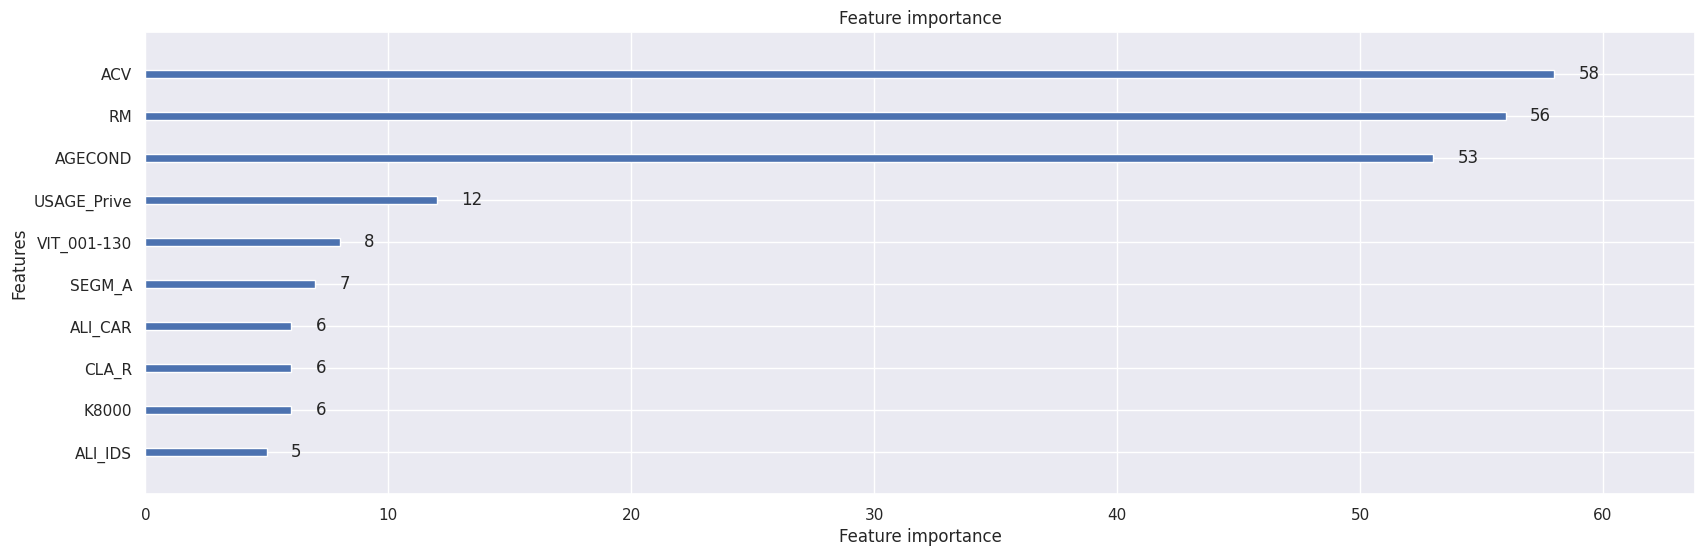

In [ ]:
from lightgbm import plot_importance
ax = plot_importance(optimized_lgbm_clf, max_num_features=10)
ax.figure.set_size_inches(20, 6)
ax.figure.savefig('./ActuarialThesis/plots_clf/myLightGBMClassifierFeatureImportances.pdf')

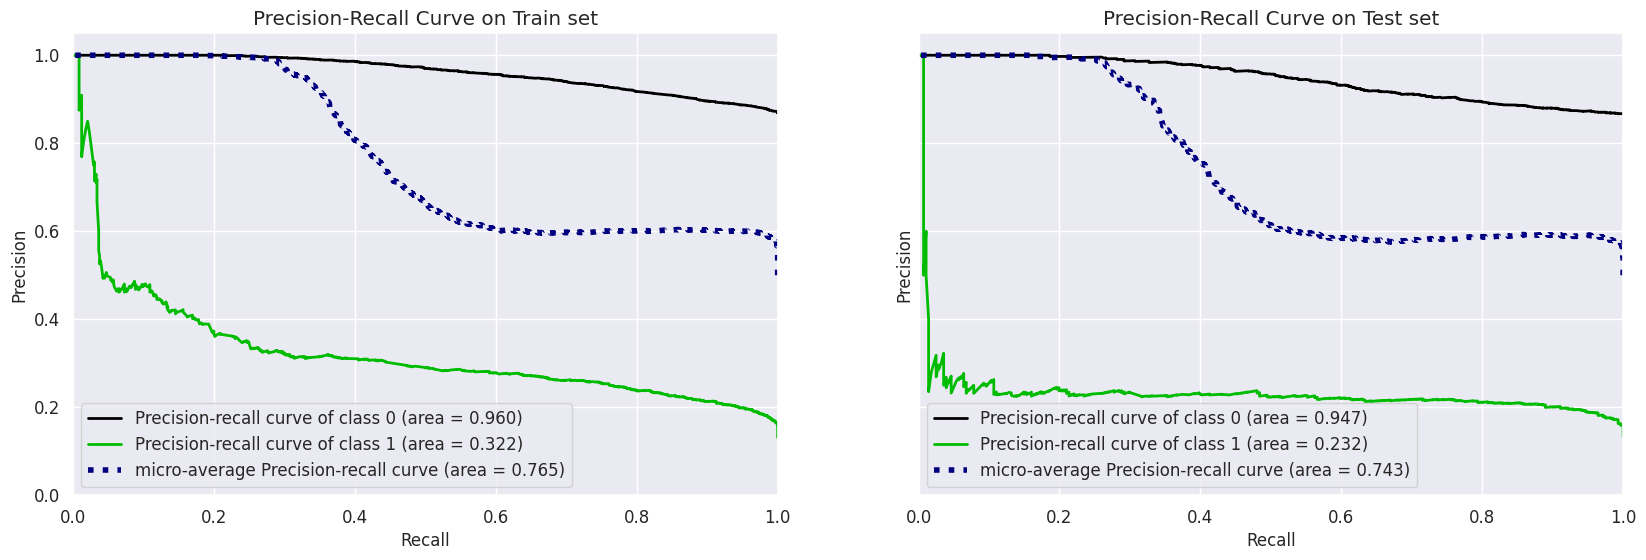

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
y_probas = optimized_lgbm_clf.predict_proba(X_train)
skplt.metrics.plot_precision_recall(y_train, y_probas, ax = ax1, title = 'Precision-Recall Curve on Train set')

y_probas = optimized_lgbm_clf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, ax = ax2, title = 'Precision-Recall Curve on Test set')

fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myLightGBMClassifierPrecisionRecallCurve.pdf', bbox_inches='tight')
plt.show();

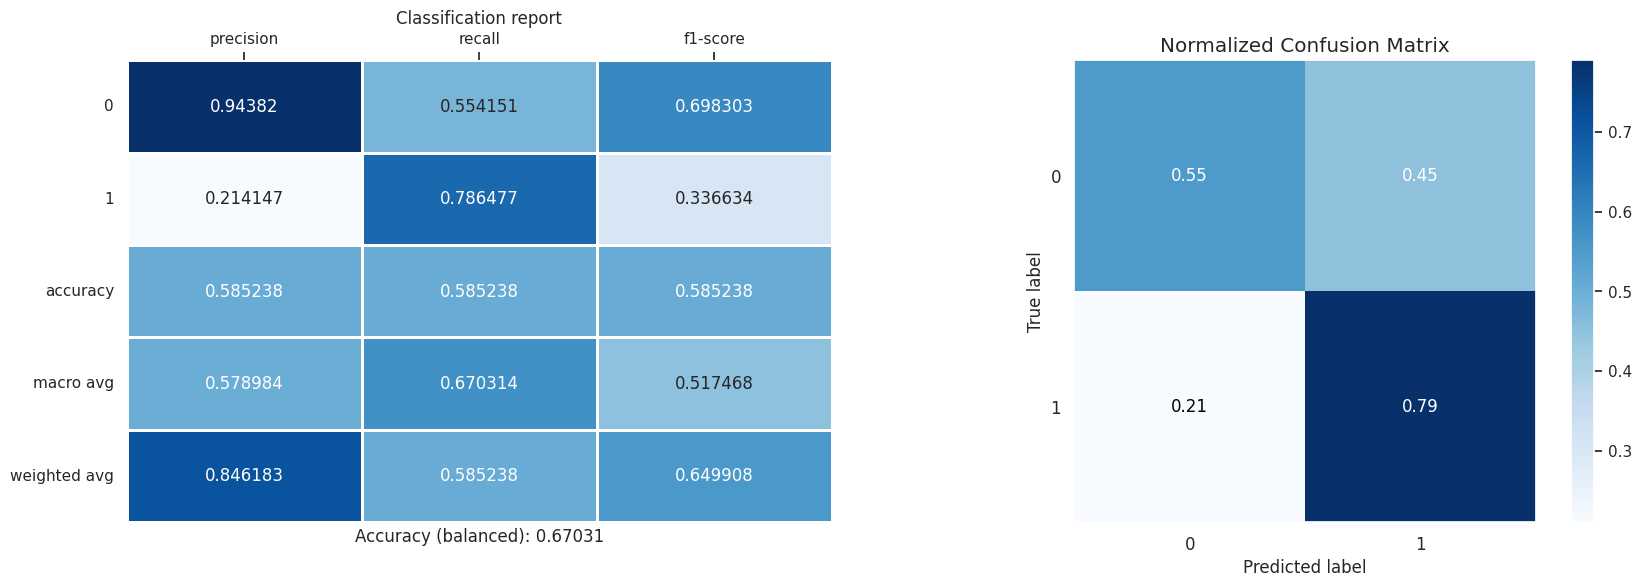

In [ ]:
fig = plot_classification_report_confusion_matrix(optimized_lgbm_clf, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myLightGBMClassifierConfusionMatrix.pdf', bbox_inches='tight')

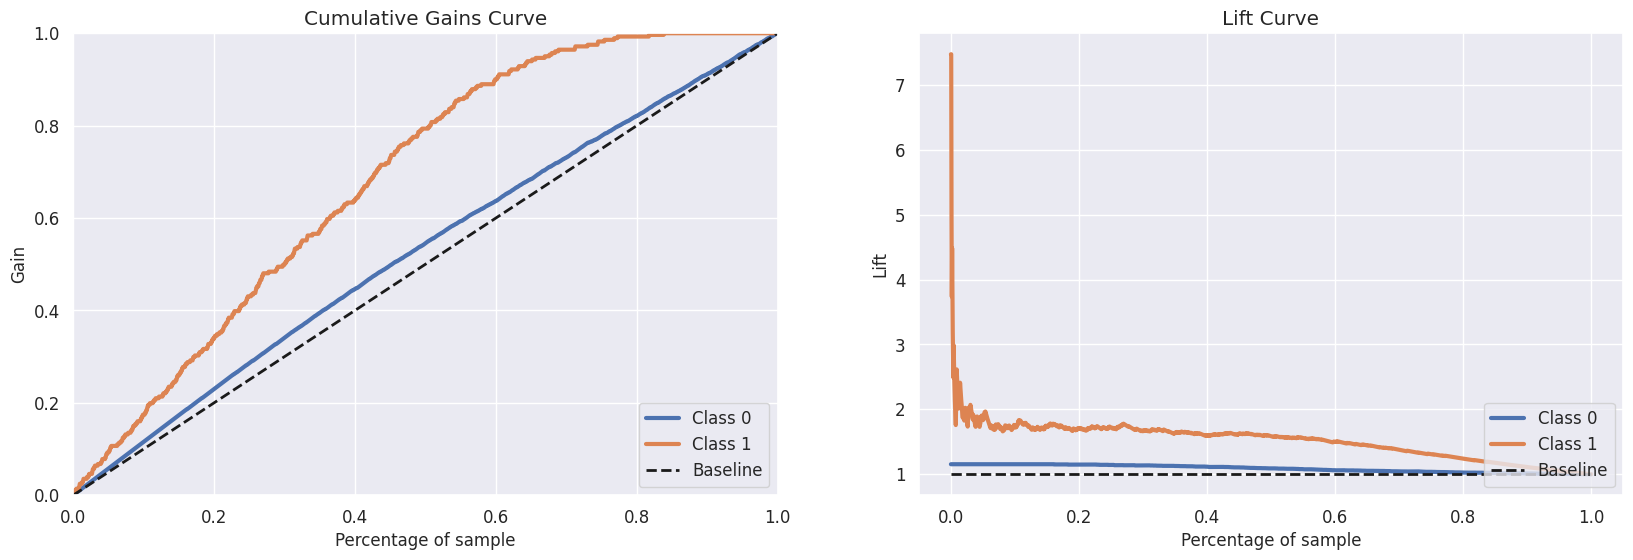

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
y_probas = optimized_lgbm_clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax = ax1)
skplt.metrics.plot_lift_curve(y_test, y_probas, ax = ax2)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myLightGBMClassifier_cumulative_gain_lift_curve.pdf', bbox_inches='tight')
plt.show();